### Methods for Training Logistic Regression: Internal vs. External Loops

In this Code, we will train a logistic regression model on a classification dataset using the LogisticRegression algorithm in three different ways:

1. **Internal Iteration Train Loop:**
In this approach, we train the logistic regression model within a loop, updating the model's parameters with each iteration based on the training data. The algorithm uses gradient descent to minimize the loss function step by step until it converges or reaches a set number of iterations.

2. **External Iteration Train Loop:**
In this method, we set the model with `max_iter = 1 and warm_start = True`, which allows the model to train once internally and keep the results for the next cycles. We then control the training process externally, enabling us to adjust the parameters and log the cost functions throughout the process. We do this in two ways:

- **Without using the `class_weight` parameter**.
- **With the `class_weight` parameter**, applying sample weights.

Finally, use the **FuncAnimation** class from **matplotlib.animation** to create an animated plot of the cost function.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from matplotlib.animation import FuncAnimation
from IPython.display import HTML  

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import warnings
# Suppress convergence warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [44]:
# Generate data
X, y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=1.0, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initial settings
iterations = 200
costs_normal = []
costs_weighted = []

classes = np.unique(y)
feature_number = X.shape[1]
print(f'Classes: {classes}, Number of features: {feature_number}')

Classes: [0 1], Number of features: 2


In [45]:
# Models for three scenarios
model_internal_loop = LogisticRegression(solver='saga', max_iter=iterations)
model_external_loop = LogisticRegression(solver='saga', max_iter=1, warm_start=True)
model_external_loop_weighted = LogisticRegression(solver='saga', max_iter=1, warm_start=True, class_weight=None)


### Plotting Decision Boundaries and Class Separation for Logistic Regression

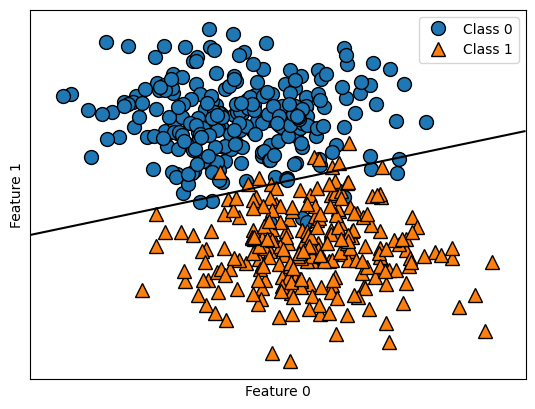

In [46]:
model_internal_loop.fit(X_train, y_train)

mglearn.plots.plot_2d_separator(model_internal_loop, X, fill=False, eps=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Class 0", "Class 1"])
plt.show()

### Train Models Externally and measure scores

In [47]:
# Function to update weights for misclassified samples
def update_weights(model, X, y, weights):
    y_pred = model.predict(X)
    incorrect = (y_pred != y)
    # Increase the weight for misclassified samples
    weights[incorrect] = 2
    dic_weights = {0: 1, 1: weights.mean()}
    return dic_weights

# Initial weights for samples
weights = np.ones_like(y_train, dtype=float)

# Training models
for i in range(iterations):
    # Training normal model
    model_external_loop.fit(X_train, y_train)
    y_pred_prob_normal = model_external_loop.predict_proba(X_train)
    cost_normal = log_loss(y_train, y_pred_prob_normal)
    costs_normal.append(cost_normal)

    # Training weighted model
    if i == 0:
        model_external_loop_weighted.fit(X_train, y_train)
    class_weight = update_weights(model_external_loop_weighted, X_train, y_train, weights)
    model_external_loop_weighted.set_params(class_weight=class_weight)
    model_external_loop_weighted.fit(X_train, y_train)
    y_pred_prob_weighted = model_external_loop_weighted.predict_proba(X_train)
    cost_weighted = log_loss(y_train, y_pred_prob_weighted)
    costs_weighted.append(cost_weighted)

print(f'Costs of model          (with internal train iteration): {model_internal_loop.score(X_test, y_test)}')
print(f'Costs of normal model   (with external train iteration): {model_external_loop.score(X_test, y_test)}')
print(f'Costs of weighted model (with external train iteration): {model_external_loop_weighted.score(X_test, y_test)}')

Costs of model          (with internal train iteration): 0.95
Costs of normal model   (with external train iteration): 0.96
Costs of weighted model (with external train iteration): 0.96


### Comparing Cost Functions of External Training Models

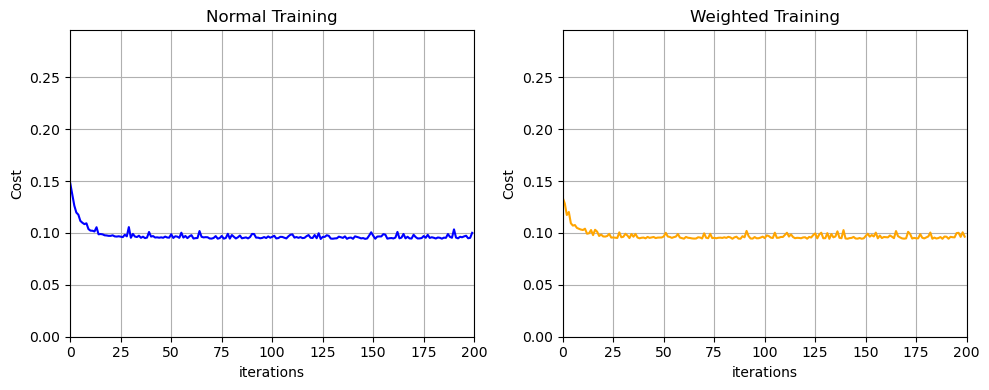

In [50]:
# Initializing plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title("Normal Training")
axes[1].set_title("Weighted Training")

ylim = np.max(costs_normal)
ylim = np.max([ylim, np.max(costs_weighted)])
for ax in axes:
    ax.set_xlim(0, iterations)
    ax.set_ylim(0, ylim*2)
    ax.set_xlabel("iterations")
    ax.set_ylabel("Cost")
    ax.grid()

axes[0].plot(range(iterations), costs_normal, color='blue')
axes[1].plot(range(iterations), costs_weighted, color='orange')

plt.tight_layout()
plt.show()

### Animated Plot: Comparing Cost Functions of External Training Models

In [49]:
lines_normal, = axes[0].plot([], [], color='blue')
lines_weighted, = axes[1].plot([], [], color='orange')

iter = 0
cycles = 1
def fun_animation(frame):
    global iter
    iter += 1
    # Exit condition after specified cycles
    if iter >= iterations * cycles:  # Stop after the permitted cycles
        # plt.close(fig)  # Closes the plot window
        return lines_normal, lines_weighted
    # Update the lines with new data
    lines_normal.set_data(range(frame + 1), costs_normal[:frame + 1])
    lines_weighted.set_data(range(frame + 1), costs_weighted[:frame + 1])
    return lines_normal, lines_weighted

# Running animation
ani = FuncAnimation(fig, fun_animation, frames=iterations, interval=20, blit=True)
plt.tight_layout()
display(HTML(ani.to_jshtml()))
plt.close()